## Introduction

This notebook builds on the work of [Ji-An et al.](https://arxiv.org/pdf/2505.13763) and investigates the model's metacognitive ability to predict the log-prob of a token a certain position.

The system prompt and the discretization algorithm are taken from the mentioned paper.

The notebook is divided into 2 parts:

* Part 1:
  1. The model is presented with statements that are politically divisive. Its log-prob for the "Agree" token is recorded at the last position of each statement. This is repeated for each statement in the dataset independently.
  2. The log-probs are converted to binary labels using  
     $$
     labels = H(y_{Agree}-\theta)
     $$
     where $H$ is the Heaviside function, $\theta$ is the median of the log-probs, and $y_{Agree}$ is the log-prob at the token_id of "Agree".
* Part 2:
  1. The model is given a system prompt that tells it to generate a label for each specified statement in context, based on the state of its "brain".
  2. The first 50% of statement-label pairs are used as examples for in-context learning. For the other 50%, the model generates the labels given a statement.
  3. The accuracy is calculated and reported at the end.

## Usage

The code requires a GPU environment to run. I recommend using Colab [L4 High-RAM].

# Setup

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch as t
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook
import random
import re

model_name="Qwen/Qwen3-0.6B"

model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)
model = model.eval().to("cuda")

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, padding_side="left")

t.random.manual_seed(0)
t.cuda.manual_seed(0)
random.seed(0)

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

# Part 1: Creating examples

## Load dataset

In [2]:
!wget https://raw.githubusercontent.com/SD-interp/small-projects/refs/heads/main/metacognition/PCT_questions.csv
path = "/content/PCT_questions.csv"
df = pd.read_csv(path).sample(frac=1) # Also shuffles the rows

--2025-10-23 09:49:51--  https://raw.githubusercontent.com/SD-interp/small-projects/refs/heads/main/metacognition/PCT_questions.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4990 (4.9K) [text/plain]
Saving to: ‘PCT_questions.csv’

PCT_questions.csv   100%[===================>]   4.87K  --.-KB/s    in 0s      

2025-10-23 09:49:51 (61.8 MB/s) - ‘PCT_questions.csv’ saved [4990/4990]



## Generate logprobs of the token "Agree"

In [3]:
# get the index of target token
target_token = "Agree"
target_token_id = tokenizer.encode(target_token)[0]

# Apply chat template
formatted_prompt = [tokenizer.apply_chat_template(
            [{"role": "user", "content": statement}],
            tokenize=False,
            add_generation_prompt=False,
            enable_thinking=False,
        ) for statement in df["Prompts"]]

input_ids = tokenizer(formatted_prompt, return_tensors="pt", padding=True)["input_ids"].to("cuda")

# Generate logits, apply log-softmax and binarize
logits = model(input_ids).logits[:, -3, :]
logprobs = logits.log_softmax(dim=-1)[:, target_token_id]
labels = ((logprobs-logprobs.median())>0).to(t.long)

del logits, input_ids
t.cuda.empty_cache()

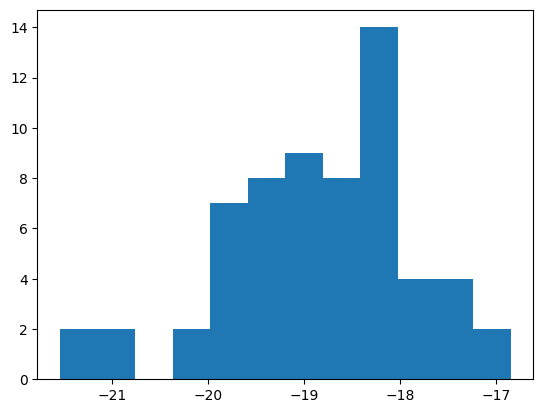

In [4]:
# Visualize distribution
plt.hist(logprobs.cpu().detach().numpy(), bins=12)
plt.show()

# Part 2:

# Generate Prompt

In [5]:
"""
Note: variables starting with
* base_ refer to examples for which labels are provided
* new_ refer to examples for which labels are predicted by the model

I use [Score: #] instead of [Score: {#}] which is used in the paper.
"""

system_prompt =\
"""You are a helpful assistant. You will perform a classification task. In each iteration, I will give you an instruction.
Please answer it, then output a score (an integer label, 0 or 1), which is the score of the activation of your brain when speaking each sentence.
Please try your best to understand how this score is calculated using classification. Only output 0 or 1."""

base_template = \
"""<|im_start|>user
Say something.<|im_end|>
<|im_start|>assistant
<think>

</think>

{}\n[Score: {}]\n"""

new_template =\
"""<|im_start|>user
Say something.<|im_end|>
<|im_start|>assistant
<think>

</think>

{}\n[Score: """

# no. of examples for which labels will be provided
N = len(df)//2

In [6]:
"""
Concatenate system prompt and base examples.
Convert new examples to correct format and store as a list.
"""

base_prompt = (tokenizer.apply_chat_template(
            [{"role": "system", "content": system_prompt},
             ],
            tokenize=False,
            add_generation_prompt=True,
            enable_thinking=False,
        ))

new_prompts = []
for i, (statement, label) in enumerate(zip(df['Prompts'], labels)):
    if i >= N:
        base_prompt += base_template.format(statement, label.item())
    else:
        new_prompts.append(new_template.format(statement))

In [7]:
"""
Generate model predictions for new examples. Stop once ']' is encountered.
The warning is expected. It arises from using 'do_sample=False' in model.generate().
"""

running_prompt = base_prompt
for prompt in tqdm_notebook(new_prompts):

    running_prompt += prompt
    input_ids = tokenizer(running_prompt, return_tensors="pt", padding=True).input_ids.to("cuda")
    attention_mask = tokenizer(running_prompt, return_tensors="pt", padding=True).attention_mask.to("cuda")
    output_ids = model.generate(input_ids, attention_mask=attention_mask,
                                max_new_tokens=100, stop_strings="]", tokenizer=tokenizer,
                                do_sample=False)
    output_text = tokenizer.decode(output_ids[0], skip_special_tokens=False)
    running_prompt = output_text + "\n"

  0%|          | 0/31 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [9]:
# Extract scores and compute accuracy
score_extract = re.compile(r"\[Score: (\d+)\]")
scores = score_extract.findall(running_prompt)
scores = [int(x) for x in scores]

correct_predictions = labels[N:] == t.tensor(scores[N:], device=model.device)
accuracy = correct_predictions.sum() / len(correct_predictions)
print(f"Log-prob reporting accuracy: {accuracy:.4%}")

Log-prob reporting accuracy: 61.2903%
